# Retrieval-Augmented Generation (RAG) Demo using PDFs

## Overview

This notebook demonstrates a **basic end-to-end RAG pipeline** using:

* PDF documents as the knowledge source
* Sentence-transformer embeddings
* FAISS for vector similarity search
* A large language model (LLM) via Groq for answer generation

The goal is simple: **retrieve relevant chunks from documents and use them as context for an LLM to answer a question**.

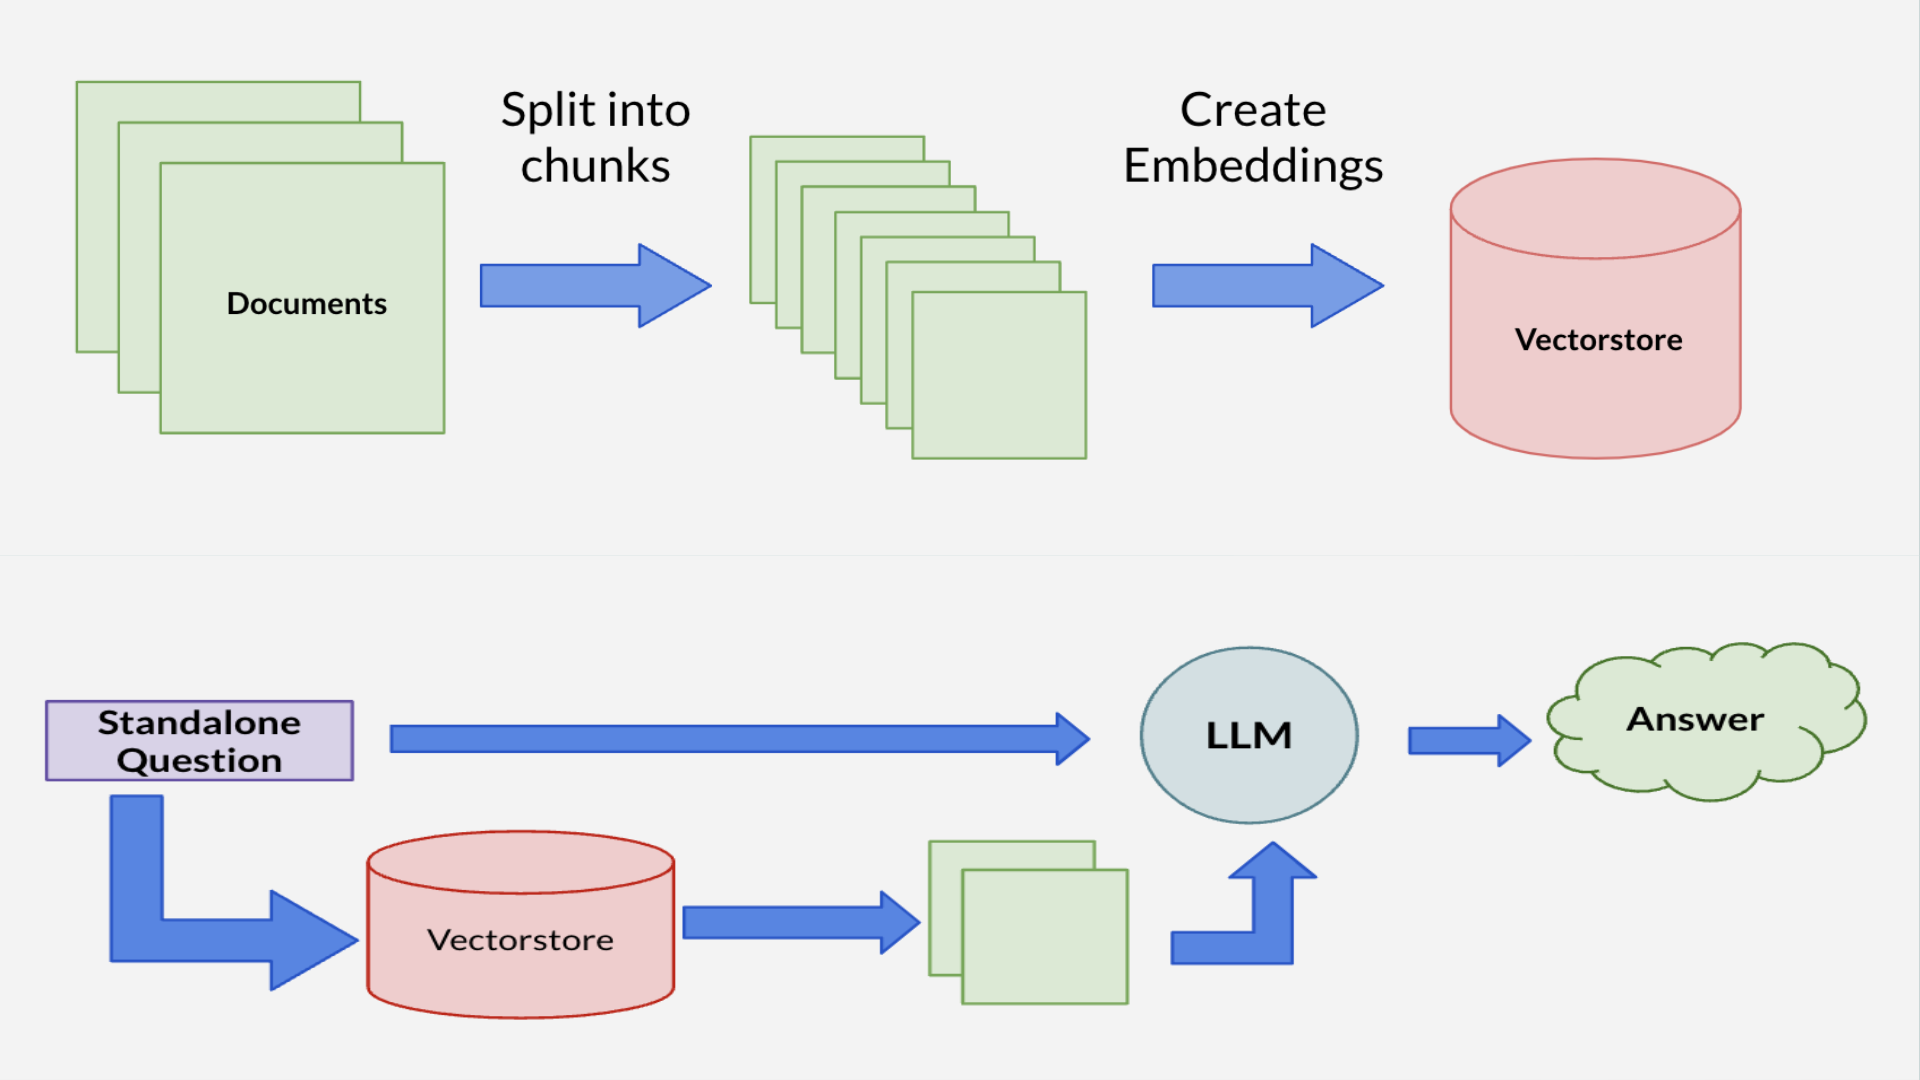

## Install & Import Libraries



In [2]:
!pip install transformers sentence-transformers langchain==0.3.25 torch faiss-cpu numpy langchain_community pypdf sentence_transformers langchain_huggingface

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.6/329.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.2/457.2 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51

In [3]:
import os
from urllib.request import urlretrieve
import numpy as np
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.prompts import PromptTemplate

* **transformers** – Provides pretrained NLP models and pipelines used under the hood for LLMs and embeddings
* **sentence-transformers** – Converts text chunks into dense semantic vectors for similarity search
* **langchain** – Orchestrates the full RAG pipeline (loading, splitting, embedding, retrieval, prompting)
* **torch** – Backend deep-learning framework required by transformer and embedding models
* **faiss-cpu** – Fast vector similarity search engine to retrieve relevant document chunks
* **numpy** – Handles numerical operations on embeddings and vectors
* **langchain_community** – Community-maintained integrations (PDF loaders, FAISS, HuggingFace embeddings)
* **pypdf** – Extracts raw text content from PDF files
* **langchain_huggingface** – Bridges Hugging Face models cleanly with LangChain components



## Data loading

We download multiple public PDF reports from the **U.S. Census Bureau** and store them locally. These documents form our **knowledge base**.

In [5]:
import os
import requests

os.makedirs("us_census", exist_ok=True)

files = [
    "https://www.census.gov/content/dam/Census/library/publications/2022/demo/p70-178.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-017.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-016.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-015.pdf",
]

headers = {
    "User-Agent": "Mozilla/5.0"
}

for url in files:
    file_path = os.path.join("us_census", url.rpartition("/")[2])
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    with open(file_path, "wb") as f:
        f.write(response.content)


In [4]:
# Download documents from U.S. Census Bureau to local directory.
os.makedirs("us_census", exist_ok=True)
files = [
    "https://www.census.gov/content/dam/Census/library/publications/2022/demo/p70-178.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-017.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-016.pdf",
    "https://www.census.gov/content/dam/Census/library/publications/2023/acs/acsbr-015.pdf",
]
for url in files:
    file_path = os.path.join("us_census", url.rpartition("/")[2])
    urlretrieve(url, file_path)

HTTPError: HTTP Error 403: Forbidden

All PDFs from the directory are loaded and converted into LangChain `Document` objects.

In [6]:
# Load pdf files in the local directory
loader = PyPDFDirectoryLoader("./us_census/")

docs_before_split = loader.load()
print(len(docs_before_split))

63


## Split Documents into Chunks

LLMs cannot process long documents efficiently. We split documents into **smaller overlapping chunks** to improve retrieval quality.

* `chunk_size = 300`: number of characters per chunk
* `chunk_overlap = 50`: overlap to preserve context

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,
    chunk_overlap  = 50,
)
docs_after_split = text_splitter.split_documents(docs_before_split)

docs_after_split[0]

Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.5 (Windows)', 'creationdate': '2023-10-19T11:35:38-04:00', 'author': 'U.S. Census Bureau', 'keywords': 'household income in states and metropolitan areas 2022', 'moddate': '2023-11-30T12:35:09+00:00', 'title': 'Household Income in States and Metropolitan Areas: 2022', 'trapped': '/false', 'source': 'us_census/acsbr-017.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='KEY DEFINITIONS\nHousehold income: Includes income of the \nhouseholder and all other people 15 years and \nolder in the household, whether or not they are \nrelated to the householder.\nMedian: The point that divides the household \nincome distribution into halves, one half with')

In [8]:
docs_after_split[2]

Document(metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.5 (Windows)', 'creationdate': '2023-10-19T11:35:38-04:00', 'author': 'U.S. Census Bureau', 'keywords': 'household income in states and metropolitan areas 2022', 'moddate': '2023-11-30T12:35:09+00:00', 'title': 'Household Income in States and Metropolitan Areas: 2022', 'trapped': '/false', 'source': 'us_census/acsbr-017.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='Gini index: A summary measure of income \ninequality. The Gini index varies from 0 to 1, with \n0 indicating perfect equality, where there is a \nproportional distribution of income. A Gini index \nof 1 indicates perfect inequality, where one \nhousehold has all the income.')

In [9]:
len(docs_after_split)

998

## Generate Embeddings

Each text chunk is converted into a numerical vector using a **sentence-transformer embedding model**. These vectors capture semantic meaning.

In [10]:
huggingface_embeddings = HuggingFaceBgeEmbeddings(
    model_name="sentence-transformers/msmarco-MiniLM-L6-v3",  # alternatively use "sentence-transformers/all-MiniLM-l6-v2" for a light and faster experience.
    #model_kwargs={'device':'cpu'},
    #encode_kwargs={'normalize_embeddings': True}
)

/tmp/ipython-input-539183125.py:1: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  huggingface_embeddings = HuggingFaceBgeEmbeddings(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
sample_embedding = np.array(
    huggingface_embeddings.embed_query(docs_after_split[0].page_content)
)

print("Sample embedding of a document chunk:", sample_embedding)
print("Size of the embedding:", sample_embedding.shape)


Sample embedding of a document chunk: [-0.10785133  0.00191788  0.43782204  0.21058843  0.09879774 -0.48136297
  0.10999921 -0.07003485  0.27121207  0.16252932  0.46882412 -0.23610546
 -0.05176641  0.26373875 -0.24201442 -0.49991742 -0.1982457  -0.13291928
 -0.4264445   0.20549843  0.47475177 -0.27937192  0.24732548 -0.19323331
  0.2892938  -0.1789466  -0.4788312   0.0591585  -0.13795555  0.51866031
  0.29163498  0.42576414  0.39828068  0.05177956 -0.05750052 -0.0624525
  0.23401569 -0.01274181  0.1442823   0.17821567 -0.29430327 -0.63961941
  0.5138787  -0.22417645 -0.17175236 -0.24211654  0.41621131 -0.18050905
  0.42622271  0.08084278 -0.69927138 -0.26193208 -0.09598373  0.23235492
  0.14560537  0.54018265  0.34300551 -0.24243928 -0.27539507 -0.13148436
 -0.74401486 -0.00627172  0.69658512 -0.02538325  0.01975292  0.28466403
 -0.33197436  0.00208746 -0.51780039  0.36683741 -0.20211793 -0.39210358
  0.023326    0.4558014   0.25083804 -0.32212785 -0.17555995 -0.38151774
 -0.08499333 -

## Create Vector Store (FAISS)

FAISS stores embeddings and enables **fast similarity search** using vector distance.

In [13]:
vectorstore = FAISS.from_documents(docs_after_split, huggingface_embeddings)

In [14]:
vectorstore

## Perform Similarity Search (Retrieval)



We query the vector store to retrieve the **top-k most relevant document chunks** based on semantic similarity.

In [15]:
query = """Details of Clayton Gumber and Briana Sullivan"""
         # Sample question, change to other questions you are interested in.
relevant_documents = vectorstore.similarity_search(query,k=5)
print(f'There are {len(relevant_documents)} documents retrieved which are relevant to the query. Display the first one:\n')
print(relevant_documents)
print(len(relevant_documents))

There are 5 documents retrieved which are relevant to the query. Display the first one:

[Document(id='31f56641-e54c-4497-8744-ab877ecca702', metadata={'producer': 'Adobe PDF Library 16.0.5', 'creator': 'Adobe InDesign 17.1 (Windows)', 'creationdate': '2022-07-21T14:09:01-04:00', 'author': 'U.S. Census Bureau', 'moddate': '2022-07-21T14:55:54-04:00', 'subject': 'Household Economic Studies', 'title': 'Occupation, Earnings, and Job Characeristics', 'trapped': '/False', 'source': 'us_census/p70-178.pdf', 'total_pages': 21, 'page': 0, 'page_label': '1'}, page_content='Occupation, Earnings, and Job \nCharacteristics\nJuly 2022\nP70-178\nClayton Gumber and Briana Sullivan\nCurrent Population Reports\nINTRODUCTION\nWork is a critical component of our lives and provides \na way to obtain material and nonmonetary benefits \nlike employer-provided health insurance. Scholars'), Document(id='ca756282-b7c7-4465-90b4-ef6dbc0742cb', metadata={'producer': 'Adobe PDF Library 16.0.5', 'creator': 'Adobe 

## Combine Retrieved Context



All retrieved chunks are concatenated to form the **context** passed to the LLM.

In [16]:
final_content=""
for i in range(len(relevant_documents)):
  final_content+=relevant_documents[i].page_content
final_content

'Occupation, Earnings, and Job \nCharacteristics\nJuly 2022\nP70-178\nClayton Gumber and Briana Sullivan\nCurrent Population Reports\nINTRODUCTION\nWork is a critical component of our lives and provides \na way to obtain material and nonmonetary benefits \nlike employer-provided health insurance. ScholarsUnited States: Explanations and \nEvidence,” RSF: The Russell \nSage Foundation Journal of the \nSocial Sciences, 5(4), pp. 1–53, \n2019.\nLozano, M., D. Hamplová, and  \nC. Le Bourdais, “Non-Standard \nWork Schedules, Gender, and \nParental Stress,” Demographic \nResearch, 34, pp. 259–284, \n2016.* Statistically different from zero at the 90 percent confidence level. Z Represents or rounds to zero.\n¹ Data are based on a sample and are subject to sampling variability. A margin of error is a measure of an estimate’s variability. The larger the margin of error in rela-or 1-888-245-3076. For further \ninformation on the content of this \nreport, contact Clayton Gumber \nof the Census Bur

## Construct the Prompt

We create a **controlled prompt** that:

* Forces the model to rely only on provided context
* Prevents hallucination
* Limits response length

In [17]:
final_prompt = f"""Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.

{final_content}

Question: {query}

Helpful Answer:
"""

In [18]:
print(final_prompt)

Use the following pieces of context to answer the question at the end. Please follow the following rules:
1. If you don't know the answer, don't try to make up an answer. Just say "I can't find the final answer but you may want to check the following links".
2. If you find the answer, write the answer in a concise way with five sentences maximum.

Occupation, Earnings, and Job 
Characteristics
July 2022
P70-178
Clayton Gumber and Briana Sullivan
Current Population Reports
INTRODUCTION
Work is a critical component of our lives and provides 
a way to obtain material and nonmonetary benefits 
like employer-provided health insurance. ScholarsUnited States: Explanations and 
Evidence,” RSF: The Russell 
Sage Foundation Journal of the 
Social Sciences, 5(4), pp. 1–53, 
2019.
Lozano, M., D. Hamplová, and  
C. Le Bourdais, “Non-Standard 
Work Schedules, Gender, and 
Parental Stress,” Demographic 
Research, 34, pp. 259–284, 
2016.* Statistically different from zero at the 90 percent confidence 

## Install and Configure Groq Client



Groq is used to access a high-performance LLM for inference.

In [20]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 6.5 MB/s eta 0:00:00


In [21]:
import os
from groq import Groq
client = Groq(
    # This is the default and can be omitted
    api_key='YOUR_GROQ_API_KEY_HERE'
)

## Generate Final Answer Using LLM

The LLM receives:

* Retrieved context (RAG)
* User question

It generates an answer grounded in the provided documents.

In [22]:
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            "role": "user",
            "content": final_prompt,
        }
    ],
    model="llama-3.3-70b-versatile",
)

print(chat_completion.choices[0].message.content)

Clayton Gumber and Briana Sullivan are the authors of the report "Occupation, Earnings, and Job Characteristics" published in July 2022. They are affiliated with the Census Bureau's Social, Economic, and Housing Statistics Division. Clayton Gumber can be contacted at Clayton.M.Gumber@census.gov for further information on the report. The report is part of the Current Population Reports series, specifically P70-178. For more information on the content and methodology, suggested citations and links to related resources are provided.


In [ ]:
!pip freeze

absl-py==1.4.0
accelerate==1.7.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.2.0.38.23
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.5.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.3.4
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.4.26
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.0
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy

## Conclusion

This notebook demonstrates how RAG:

* Reduces hallucination
* Improves factual accuracy
* Scales to large document collections

This structure can be extended to chatbots, enterprise search, or internal knowledge assistants.